mHealth에서 (subject 1명, activity 1개) → 전처리 끝낸 mhealth_X.npy 저장

mm-Fit에서 (subject 1명, activity 1개) → 전처리 끝낸 mmfit_X.npy 저장

각각을 이용해 모델 학습(같은 데이터로 overfit 해도 됨) → mhealth_model.pt, mmfit_model.pt 저장

infer.py 작성(모델 로드 + X.npy 로드 + latency 측정)

폴더로 묶어서 전달

# MHEALTH `.npy` 만들기
- `Knees bending` , `Subject_10`

In [1]:
# export_mhealth_subject10_knees_npy.py
import os, json
import numpy as np
import pandas as pd

def extract_longest_contiguous_segment(df: pd.DataFrame, label_col: str, label_val: int):
    """df에서 label_col==label_val인 구간들 중 '가장 긴 연속 구간' 1개를 반환."""
    idx = np.flatnonzero(df[label_col].values == label_val)
    if len(idx) == 0:
        return None

    # 연속 구간 split (idx 차이가 1이 아니면 끊긴 것)
    breaks = np.where(np.diff(idx) != 1)[0] + 1
    chunks = np.split(idx, breaks)

    longest = max(chunks, key=len)
    return df.iloc[longest[0] : longest[-1] + 1].copy()

def main():
    DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET"
    OUT_DIR  = "/content/drive/MyDrive/Colab Notebooks/rpi_package/data"
    os.makedirs(OUT_DIR, exist_ok=True)

    SUBJECT_ID = 10
    ACT_ID     = 8
    ACT_NAME   = "Knees bending"
    FS         = 50

    COLUMN_NAMES = [
        'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
        'ecg_1', 'ecg_2',
        'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
        'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
        'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
        'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
        'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
        'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
        'activity_id'
    ]

    # ✅ 너 코드에서 쓰던 feature map 그대로 가져가되, act_id=8에 대해 정의
    FEATURES = [
        'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
        'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
        'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
        'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
        'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
    ]

    file_path = os.path.join(DATA_DIR, f"mHealth_subject{SUBJECT_ID}.log")
    if not os.path.exists(file_path):
        raise FileNotFoundError(file_path)

    df = pd.read_csv(file_path, sep="\t", header=None)
    df = df.iloc[:, :len(COLUMN_NAMES)]
    df.columns = COLUMN_NAMES

    seg = extract_longest_contiguous_segment(df, "activity_id", ACT_ID)
    if seg is None:
        raise RuntimeError(f"No samples for activity_id={ACT_ID} in subject{SUBJECT_ID}")

    X = seg[FEATURES].values.astype(np.float32)  # [T, C]

    # ✅ trial-level z-score (너 prepare_trial_list와 동일 컨셉)
    mean = X.mean(axis=0)
    std  = X.std(axis=0) + 1e-6
    Xn = (X - mean) / std

    out_x = os.path.join(OUT_DIR, "mhealth_X.npy")
    np.save(out_x, Xn)

    meta = {
        "dataset": "mHealth",
        "subject": f"subject{SUBJECT_ID}",
        "activity_id": ACT_ID,
        "activity_name": ACT_NAME,
        "fs": FS,
        "T": int(Xn.shape[0]),
        "C": int(Xn.shape[1]),
        "features": FEATURES,
        "normalization": "trial_zscore",
    }
    with open(os.path.join(OUT_DIR, "mhealth_meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    print(f"[OK] Saved: {out_x}  shape={Xn.shape}, fs={FS}")
    print(f"[OK] Saved: {os.path.join(OUT_DIR, 'mhealth_meta.json')}")

if __name__ == "__main__":
    main()


[OK] Saved: /content/drive/MyDrive/Colab Notebooks/rpi_package/data/mhealth_X.npy  shape=(2867, 15), fs=50
[OK] Saved: /content/drive/MyDrive/Colab Notebooks/rpi_package/data/mhealth_meta.json


# `.npy` check

Loaded X: /content/drive/MyDrive/Colab Notebooks/rpi_package/data/mhealth_X.npy
Shape: (T=2867, C=15), fs=50.0 Hz, duration=57.34 sec
Features: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z', 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z']

Mean(abs(mean)) over channels: 3.3379154729118454e-07
Mean(std) over channels: 0.9999936819076538


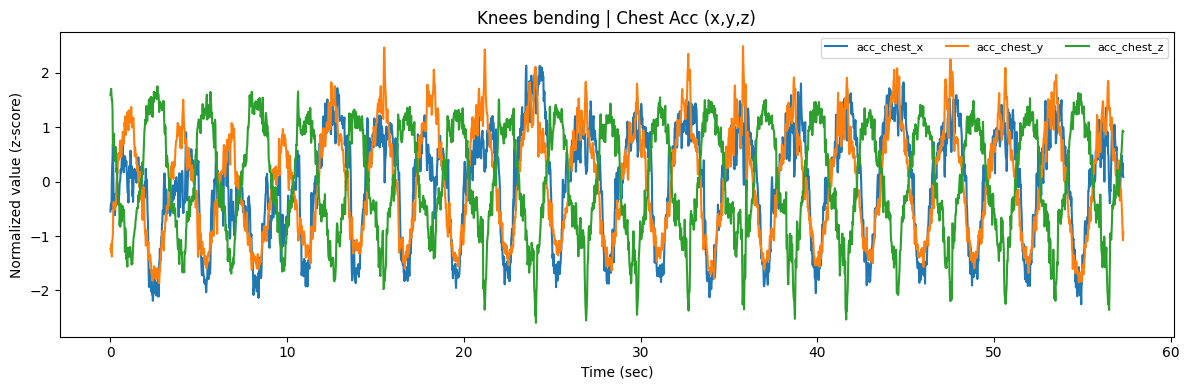

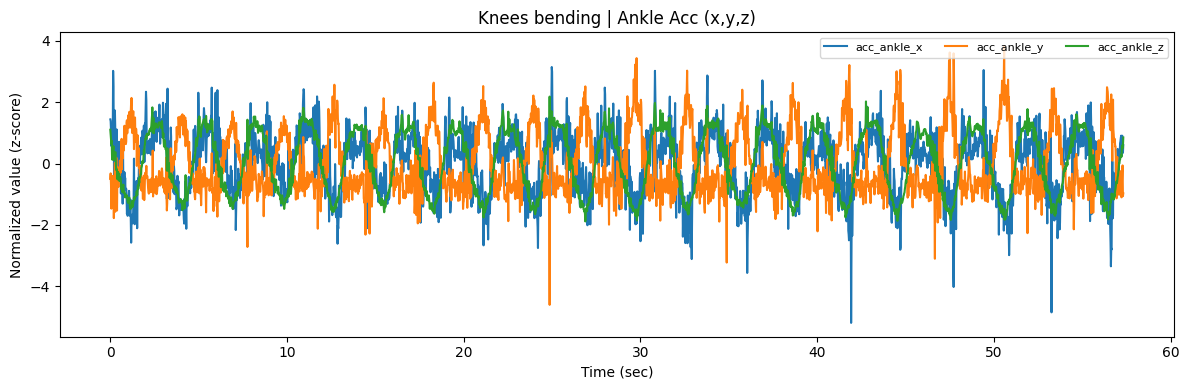

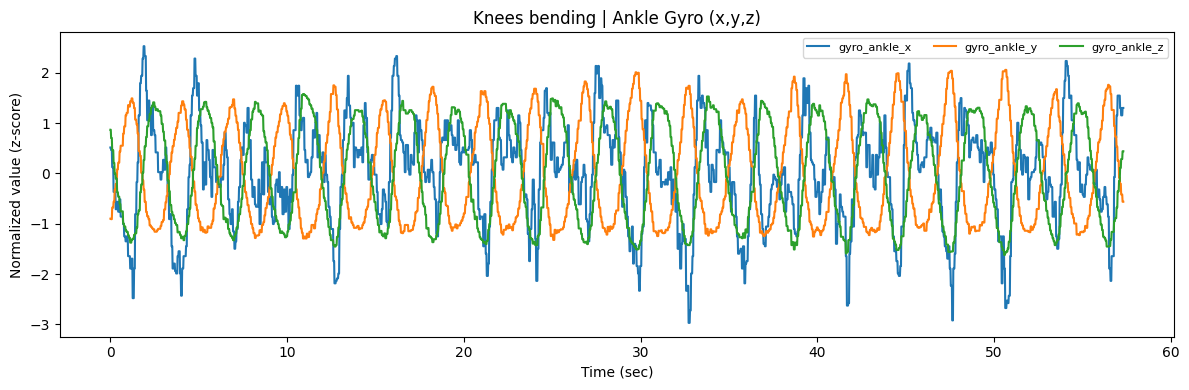

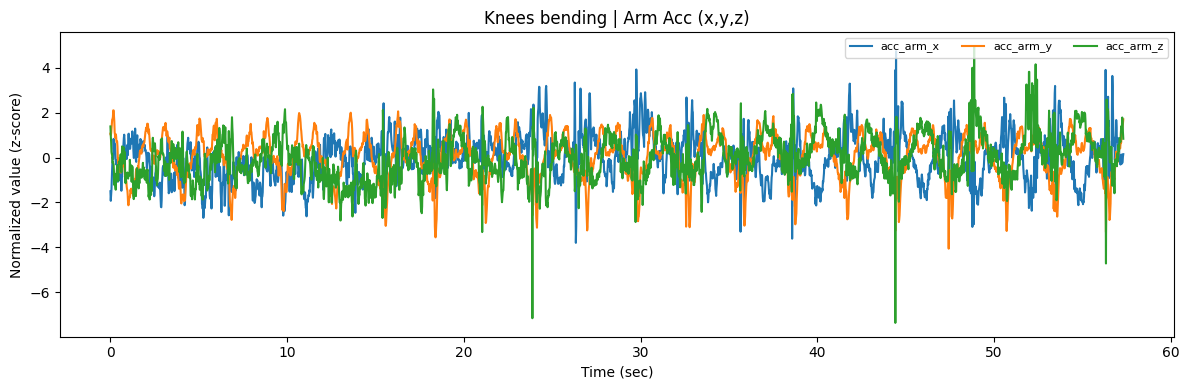

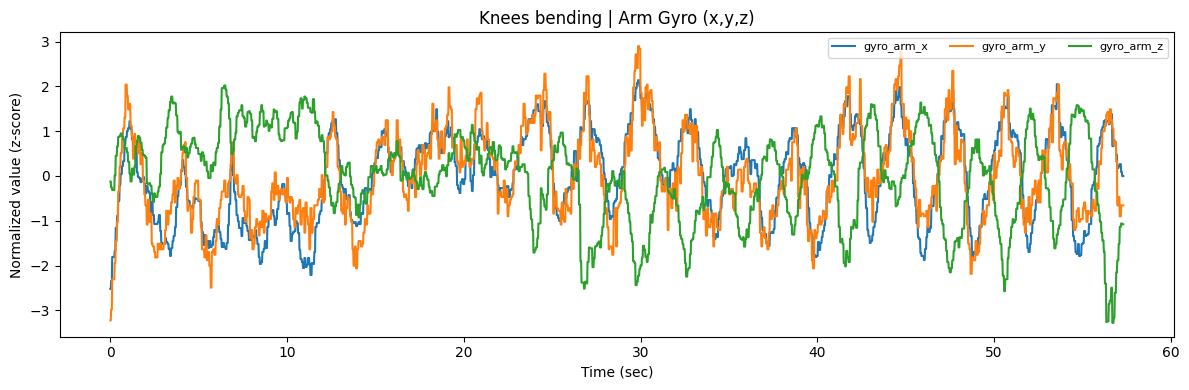

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

x_path = "/content/drive/MyDrive/Colab Notebooks/rpi_package/data/mhealth_X.npy"
meta_path = "/content/drive/MyDrive/Colab Notebooks/rpi_package/data/mhealth_meta.json"

X = np.load(x_path).astype(np.float32)  # [T, C]
with open(meta_path, "r") as f:
    meta = json.load(f)

fs = float(meta.get("fs", 50))
features = meta.get("features", [f"ch{i}" for i in range(X.shape[1])])

T, C = X.shape
dur = T / fs

print(f"Loaded X: {x_path}")
print(f"Shape: (T={T}, C={C}), fs={fs} Hz, duration={dur:.2f} sec")
print("Features:", features)

# z-score sanity check
ch_mean = X.mean(axis=0)
ch_std  = X.std(axis=0)
print("\nMean(abs(mean)) over channels:", float(np.mean(np.abs(ch_mean))))
print("Mean(std) over channels:", float(np.mean(ch_std)))

t = np.arange(T) / fs

def plot_group(title, names):
    idx = [features.index(n) for n in names if n in features]
    if not idx:
        print(f"[Skip] Missing features for {title}: {names}")
        return
    plt.figure(figsize=(12, 4))
    for i in idx:
        plt.plot(t, X[:, i], label=features[i])
    plt.xlabel("Time (sec)")
    plt.ylabel("Normalized value (z-score)")
    plt.title(title)
    plt.legend(loc="upper right", ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()

# 15ch 구성(너가 저장한 FEATURES 기준)
plot_group("Knees bending | Chest Acc (x,y,z)",
           ["acc_chest_x","acc_chest_y","acc_chest_z"])

plot_group("Knees bending | Ankle Acc (x,y,z)",
           ["acc_ankle_x","acc_ankle_y","acc_ankle_z"])

plot_group("Knees bending | Ankle Gyro (x,y,z)",
           ["gyro_ankle_x","gyro_ankle_y","gyro_ankle_z"])

plot_group("Knees bending | Arm Acc (x,y,z)",
           ["acc_arm_x","acc_arm_y","acc_arm_z"])

plot_group("Knees bending | Arm Gyro (x,y,z)",
           ["gyro_arm_x","gyro_arm_y","gyro_arm_z"])


# MM-Fit `.npy` 만들기
- `push-ups` , `Session = w01 (ID=0)`

In [3]:
import os, json
import numpy as np
import pandas as pd

def load_mmfit_meta(meta_csv_path: str,
                    target_exercises: set,
                    only_reps=None,
                    require_device: str = "sw_r"):
    """
    meta.csv 로딩.
    ✅ NEW DATA expected columns:
      participant, session, set_id, exercise, reps, fs, npz_path
    """
    if not os.path.exists(meta_csv_path):
        raise FileNotFoundError(f"[MM-Fit] meta csv not found: {meta_csv_path}")

    meta = pd.read_csv(meta_csv_path)

    # ✅ participant required
    need_cols = ["participant", "session", "set_id", "exercise", "reps", "fs", "npz_path"]
    for c in need_cols:
        if c not in meta.columns:
            raise ValueError(f"[MM-Fit] meta csv missing column: {c} (have={list(meta.columns)})")

    meta["exercise"] = meta["exercise"].astype(str).str.strip()
    meta["session"] = meta["session"].astype(str).str.strip()

    # participant sanitize
    meta["participant"] = pd.to_numeric(meta["participant"], errors="coerce")
    meta = meta.dropna(subset=["participant"]).copy()
    meta["participant"] = meta["participant"].astype(int)

    # device 필터 (device 컬럼 있을 때만)
    if "device" in meta.columns and require_device is not None:
        meta = meta[meta["device"].astype(str).str.strip() == require_device].copy()

    # exercise 필터
    meta = meta[meta["exercise"].isin(set(target_exercises))].copy()

    # reps 필터 (원하면)
    if only_reps is not None:
        meta = meta[meta["reps"].round().astype(int) == int(only_reps)].copy()

    # npz_path 존재 확인
    meta["npz_path"] = meta["npz_path"].astype(str)
    ok = meta["npz_path"].apply(lambda p: os.path.exists(p))
    meta = meta[ok].copy()

    meta = meta.sort_values(["participant", "session", "exercise", "set_id"]).reset_index(drop=True)
    return meta

def _is_finite_np(x: np.ndarray) -> bool:
    return np.isfinite(x).all()

def prepare_trial_list_mmfit(meta_rows: pd.DataFrame,
                            expected_fs: float,
                            skip_nonfinite: bool = True,
                            verbose_skip: bool = True):
    """
    - 각 row = 1 trial
    - count label = reps
    - per-trial z-score
    - ✅ nonfinite(X에 NaN/Inf)면 스킵 (skip only)
    """
    trial_list = []
    skipped = []  # (reason, npz_path)

    for _, r in meta_rows.iterrows():
        npz_path = str(r["npz_path"])
        try:
            d = np.load(npz_path, allow_pickle=True)
        except Exception:
            skipped.append(("npz_load_fail", npz_path))
            continue

        if "X" not in d.files:
            skipped.append(("missing_X", npz_path))
            continue

        X = d["X"].astype(np.float32)  # (T,C)
        reps = float(r["reps"])
        sid = str(r["session"])
        pid = int(r["participant"])
        set_id = int(r["set_id"])
        ex = str(r["exercise"])

        # fs check
        try:
            fs_npz = float(d["fs"]) if "fs" in d.files else float(r["fs"])
        except Exception:
            fs_npz = float(r["fs"])

        if abs(fs_npz - float(expected_fs)) > 1e-3:
            raise ValueError(
                f"[MM-Fit] fs mismatch for {npz_path}: fs_npz={fs_npz}, expected_fs={expected_fs}. "
                f"-> extractor 단계에서 TARGET_FS를 expected_fs로 통일하세요."
            )

        # ✅ skip nonfinite raw X
        if skip_nonfinite and (not _is_finite_np(X)):
            skipped.append(("nonfinite_X", npz_path))
            continue

        # per-trial z-score
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        std = np.where(std < 1e-6, 1e-6, std).astype(np.float32)
        norm_np = (X - mean) / std

        # ✅ (안전) 정규화 후에도 nonfinite면 스킵
        if skip_nonfinite and (not _is_finite_np(norm_np)):
            skipped.append(("nonfinite_after_norm", npz_path))
            continue

        trial_list.append({
            "data": norm_np,              # (T,C)
            "count": float(reps),         # trial total count
            "meta": f"subj{pid}_{sid}_set{set_id:02d}_{ex}",
            "participant": pid,
            "session": sid,
            "exercise": ex,
            "npz_path": npz_path,
        })

    if verbose_skip and len(skipped) > 0:
        print(f"[MM-Fit] Skipped {len(skipped)} trials (nonfinite/load issues). Examples:")
        for i in range(min(5, len(skipped))):
            print("  -", skipped[i][0], ":", skipped[i][1])

    return trial_list, skipped

def export_one_mmfit_trial_w09_dumbbell_rows():
    OUT_DIR = "/content/drive/MyDrive/Colab Notebooks/rpi_package/data"
    os.makedirs(OUT_DIR, exist_ok=True)

    META_CSV = "/content/drive/MyDrive/Colab Notebooks/HAR_data/mmfit_imu_3ex_trials/meta_sw_r_dumbbell_rows_lunges_pushups.csv"
    EXPECTED_FS = 100
    REQUIRE_DEVICE = "sw_r"

    TARGET_SESSION = "w09"
    TARGET_EX = "dumbbell_rows"

    # 1) meta 로드 (pushups만)
    meta = load_mmfit_meta(
        meta_csv_path=META_CSV,
        target_exercises={TARGET_EX},
        only_reps=None,
        require_device=REQUIRE_DEVICE
    )

    # 2) 세션 필터 (w01)
    meta = meta[meta["session"].astype(str).str.strip() == TARGET_SESSION].copy()
    if len(meta) == 0:
        raise RuntimeError(f"No rows after filtering: session={TARGET_SESSION}, exercise={TARGET_EX}")

    # 3) trial list 만들기 (nonfinite 제거 + z-score 포함)
    trials, skipped = prepare_trial_list_mmfit(
        meta,
        expected_fs=EXPECTED_FS,
        skip_nonfinite=True,
        verbose_skip=True
    )
    if len(trials) == 0:
        raise RuntimeError(f"No valid trials after filtering nonfinite/load issues: session={TARGET_SESSION}")

    # 4) 여기서는 '첫 번째 유효 trial'을 대표로 선택 (결정적/재현성 좋음)
    chosen = trials[0]
    X = chosen["data"].astype(np.float32)  # (T,C) already z-scored

    # 5) 저장
    out_x = os.path.join(OUT_DIR, "mmfit_X.npy")
    np.save(out_x, X)

    # ✅ 너가 말한 공식 매핑을 메타에 명시
    # (meta.csv에도 participant가 들어있으니 둘이 일치하는지 같이 남기면 더 안전)
    official_session_to_participant = {"w09": 1}

    meta_out = {
        "dataset": "MM-Fit",
        "session": TARGET_SESSION,
        "exercise": TARGET_EX,
        "participant_from_meta_csv": int(chosen["participant"]),
        "participant_from_official_mapping": int(official_session_to_participant[TARGET_SESSION]),
        "fs": EXPECTED_FS,
        "T": int(X.shape[0]),
        "C": int(X.shape[1]),
        "normalization": "trial_zscore",
        "device_filter": REQUIRE_DEVICE,
        "selected_rule": "first_valid_trial_after_filters",
        "selected_trial_meta": chosen["meta"],
        "source_npz_path": chosen["npz_path"],
        "n_candidates_in_session": int(len(trials)),
        "n_skipped_in_session": int(len(skipped)),
    }

    out_meta = os.path.join(OUT_DIR, "mmfit_meta.json")
    with open(out_meta, "w") as f:
        json.dump(meta_out, f, indent=2)

    print(f"[OK] Saved: {out_x}  shape={X.shape}, fs={EXPECTED_FS}")
    print(f"[OK] Saved: {out_meta}")
    print("[Picked]", meta_out["selected_trial_meta"])
    if meta_out["participant_from_meta_csv"] != meta_out["participant_from_official_mapping"]:
        print("[WARN] participant mismatch between meta.csv and official mapping! "
              "Check which one you want to report.")

export_one_mmfit_trial_w09_dumbbell_rows()


[OK] Saved: /content/drive/MyDrive/Colab Notebooks/rpi_package/data/mmfit_X.npy  shape=(1615, 6), fs=100
[OK] Saved: /content/drive/MyDrive/Colab Notebooks/rpi_package/data/mmfit_meta.json
[Picked] subj1_w09_set06_dumbbell_rows


# `.npy` check

Loaded X: /content/drive/MyDrive/Colab Notebooks/rpi_package/data/mmfit_X.npy
Shape: (T=1615, C=6), fs=100.0 Hz, duration=16.15 sec
Picked: subj1_w09_set06_dumbbell_rows

Mean(abs(mean)) over channels: 5.251452535048884e-07
Mean(std) over channels: 1.0


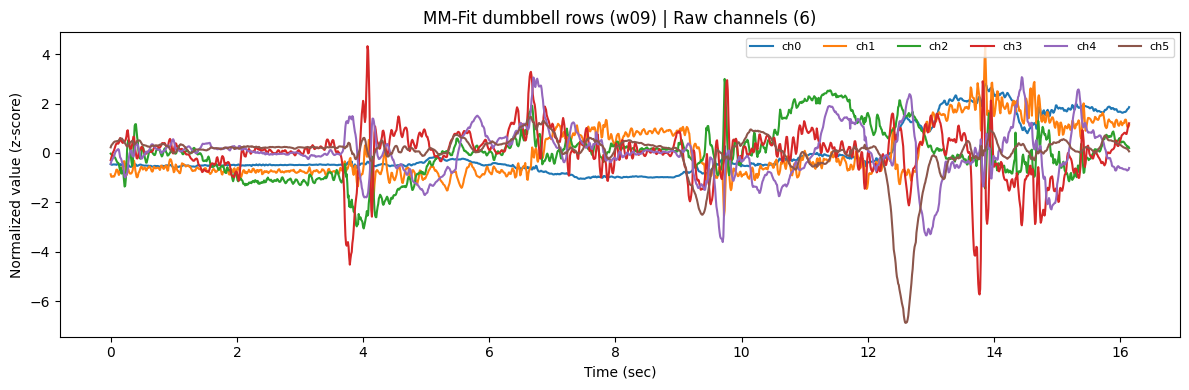

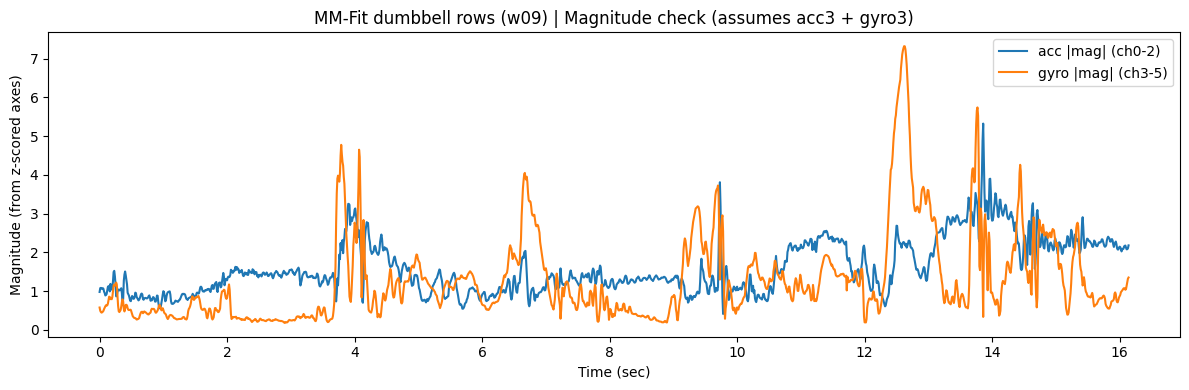

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt

x_path = "/content/drive/MyDrive/Colab Notebooks/rpi_package/data/mmfit_X.npy"
meta_path = "/content/drive/MyDrive/Colab Notebooks/rpi_package/data/mmfit_meta.json"

X = np.load(x_path).astype(np.float32)  # [T, C]
with open(meta_path, "r") as f:
    meta = json.load(f)

fs = float(meta.get("fs", 100))
T, C = X.shape
t = np.arange(T) / fs

print(f"Loaded X: {x_path}")
print(f"Shape: (T={T}, C={C}), fs={fs} Hz, duration={T/fs:.2f} sec")
print("Picked:", meta.get("selected_trial_meta"))

# z-score sanity check
ch_mean = X.mean(axis=0)
ch_std  = X.std(axis=0)
print("\nMean(abs(mean)) over channels:", float(np.mean(np.abs(ch_mean))))
print("Mean(std) over channels:", float(np.mean(ch_std)))

# 1) raw channels
plt.figure(figsize=(12,4))
for c in range(C):
    plt.plot(t, X[:, c], label=f"ch{c}")
plt.xlabel("Time (sec)")
plt.ylabel("Normalized value (z-score)")
plt.title("MM-Fit dumbbell rows (w09) | Raw channels (6)")
plt.legend(ncol=6, fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()

# 2) (가정) first 3 = acc, last 3 = gyro magnitude
if C == 6:
    acc_mag = np.sqrt((X[:, 0]**2 + X[:, 1]**2 + X[:, 2]**2))
    gyro_mag = np.sqrt((X[:, 3]**2 + X[:, 4]**2 + X[:, 5]**2))

    plt.figure(figsize=(12,4))
    plt.plot(t, acc_mag, label="acc |mag| (ch0-2)")
    plt.plot(t, gyro_mag, label="gyro |mag| (ch3-5)")
    plt.xlabel("Time (sec)")
    plt.ylabel("Magnitude (from z-scored axes)")
    plt.title("MM-Fit dumbbell rows (w09) | Magnitude check (assumes acc3 + gyro3)")
    plt.legend()
    plt.tight_layout()
    plt.show()
